# images
---
Notebook to train and evaluate convolutional neural network (CNN) models for e/gamma PID and energy reconstruction.

---
## Initialisation

In [1]:
# Basic import(s)
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# Set Keras backend
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Keras import(s)
import keras
import keras.backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, Activation, Flatten, GRU, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, Reshape, Lambda, AveragePooling2D, Multiply
from keras.models import Model
from keras.utils.vis_utils import plot_model

# TensorFlow import(s)
import tensorflow as tf

# Project import(s)
# -- Add module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    pass
# ...

Using TensorFlow backend.


Load data from HDF5 file.

In [2]:
# Define variables
nb_samples = 50000
file_pattern = '../data/hdf/images_{}.h5'

# Load data from file(s)
data = dict()
classes = ['Zee', 'Wmmunu']
for cls in classes:
    with h5py.File(file_pattern.format(cls), 'r') as hf:
        print "Taking {}/{} {} samples.".format(nb_samples, len(hf['egamma']), cls)
        data[cls] = hf['egamma'][:nb_samples]
        pass
    pass

Taking 50000/1000000 Zee samples.
Taking 50000/57430 Wmmunu samples.


Concatenate samples for all classes.

In [3]:
target = [icls * np.ones(data[cls].shape[0]) for icls,cls in enumerate(classes)]
data   = [data[cls] for cls in classes]
data   = np.concatenate(data)
target = np.concatenate(target)

# Add `target` column to concatenated dataset
from numpy.lib.recfunctions import append_fields
data = append_fields(data, 'target', target, dtypes=np.int)

Inspect the data.

In [4]:
variables = list(data.dtype.names)

print "Read {} events.".format(data.shape[0])
print "Variables:"
for var in variables:
    print "  {}".format(var)
    pass

Read 100000 events.
Variables:
  eventNumber
  mcChannelNumber
  runNumber
  actualInteractionsPerCrossing
  averageInteractionsPerCrossing
  isMC
  analysisType
  NvtxReco
  jets_highestBtagMV2c10
  jets_highestBtagDL1_pb
  jets_highestBtagDL1_pc
  jets_highestBtagDL1_pu
  BC_distanceFromFront
  BC_filledBunches
  Z_m
  Z_pt
  Z_eta
  Z_phi
  tag_type
  tag_et_calo
  tag_pt_track
  tag_eta
  tag_phi
  tag_charge
  tag_z0
  tag_d0
  tag_sigmad0
  tag_truth_matched
  tag_truth_pt
  tag_truth_phi
  tag_truth_eta
  tag_truth_E
  tag_truth_pdgId
  tag_truth_parent_pdgId
  p_isCentral
  p_hasTrack
  p_hasVertex
  p_et_calo
  p_pt_track
  p_eta
  p_phi
  p_charge
  p_qOverP
  p_z0
  p_d0
  p_sigmad0
  p_dPOverP
  p_weta2
  p_Reta
  p_Rphi
  p_Eratio
  p_f1
  p_f3
  p_Rhad
  p_Rhad1
  p_deltaEta1
  p_deltaPhiRescaled2
  p_TRTPID
  p_LHValue
  p_etcone20
  p_etcone30
  p_etcone40
  p_etcone20ptCorrection
  p_etcone30ptCorrection
  p_etcone40ptCorrection
  p_ptcone20
  p_ptcone30
  p_ptcone40
 

Make sure that no data is corrupted.

In [5]:
assert not (any(map(np.any, map(np.isnan, [data[var] for var in variables]))) or any(map(np.any, map(np.isinf, [data[var] for var in variables]))))

````
@TODO: Reweight?
...
````

Prepare training inputs and -labels arrays, scaling energy from `MeV` to `GeV`. (?)

In [23]:
X = [np.expand_dims(data['image_layer{}'.format(idx)] / 1000., axis=-1) for idx in range(4)]
Y = [np.abs(data['target']) == 0, data['p_truth_pt'] / 1000.]
scalar_features = ['p_charge', 'p_dPOverP', 'p_sigmad0', 'p_z0', 'p_TRTPID', 'p_deltaEta1', 'p_deltaPhiRescaled2']
S = np.array(data[scalar_features].tolist())

this next cell takes the first (3d) set of 4 images, checks their 2d size, makes upsampling scale, sets the expected size of the inputs to be the size of the images, and upsamples them


In [35]:
input_test = [x[0] for x in X]
print [x.shape[:2] for x in input_test]

from keras.layers import UpSampling2D

upsampling_scales = [( 8, 32), ( 1, 32), ( 8,  8), (16, 16)]

inputs = [Input(shape=x.shape) for x in input_test]
upsampled = [UpSampling2D(size=sz)(i) for (sz,i) in zip(upsampling_scales, inputs)]

mdl = Model(inputs, upsampled)

[(16, 4), (128, 4), (16, 16), (8, 8)]


In [30]:
input_test = [x[:10] for x in X]
output_test = mdl.predict(input_test)
print [i[0].shape for i in input_test]
print [o[0].shape for o in output_test]

[(16, 4, 1), (128, 4, 1), (16, 16, 1), (8, 8, 1)]
[(128, 128, 1), (128, 128, 1), (128, 128, 1), (128, 128, 1)]


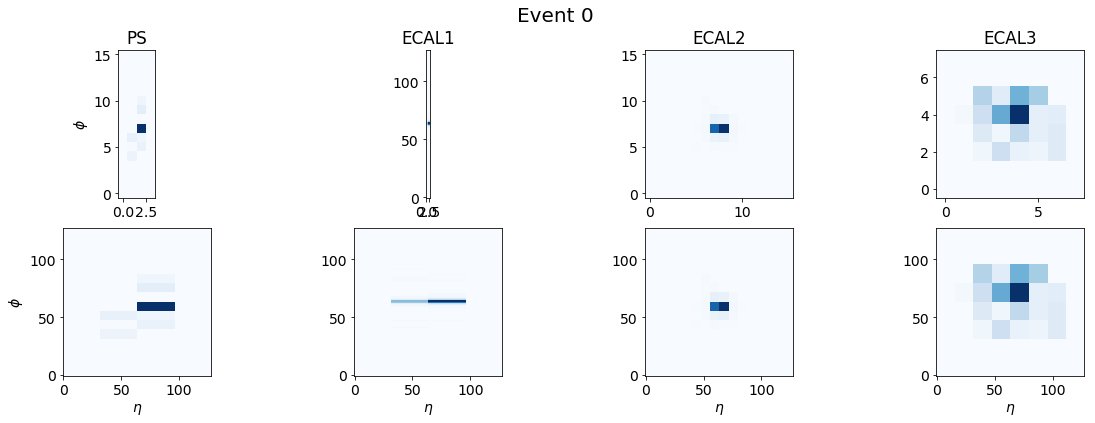

In [9]:
# Style
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

# Create figure
fig, ax = plt.subplots(2, 4, figsize=(20,6))

# Event number
ix_ev = 0

# Plot "images"
for col in range(4):
    ax[0][col].imshow(input_test [col][ix_ev][:,:,0], origin='sw', cmap='Blues')
    ax[1][col].imshow(output_test[col][ix_ev][:,:,0], origin='sw', cmap='Blues')

    # Decorations
    ax[0][col].set_title('PS' if col == 0 else 'ECAL{}'.format(col))
    ax[1][col].set_xlabel(r'$\eta$')
    if col == 0:
        ax[0][col].set_ylabel(r'$\phi$')
        ax[1][col].set_ylabel(r'$\phi$')
        pass
    pass

# Decorations
plt.suptitle('Event {}'.format(ix_ev), fontsize=20)

# Show
plt.show()

Filter out non-barrel candidates.

In [10]:
"""
# Candidate mask
msk_barrel = np.ones((X[0].shape[0],)).astype(bool)
for x in X:
    # Require all layers to have energy deposits
    msk_barrel &= x.sum(axis=(1,2,3)) > 0
    pass
print "Filtering out {} non-barrel candidates.".format(np.sum(~msk_barrel))
X = [x[msk_barrel] for x in X]
Y = [y[msk_barrel] for y in Y]
"""

'\n# Candidate mask\nmsk_barrel = np.ones((X[0].shape[0],)).astype(bool)\nfor x in X:\n    # Require all layers to have energy deposits\n    msk_barrel &= x.sum(axis=(1,2,3)) > 0\n    pass\nprint "Filtering out {} non-barrel candidates.".format(np.sum(~msk_barrel))\nX = [x[msk_barrel] for x in X]\nY = [y[msk_barrel] for y in Y]\n'

Split into training- and test set.

In [11]:
N    = X[0].shape[0]  # Number of samples
frac = 0.8            # Training fraction

# Get training-sample mask
idx_train = np.random.choice(N, int(N * frac), replace=False)
msk_train = np.zeros((N,)).astype(bool)
msk_train[idx_train] = True

# Split dataset
X_train = [x[ msk_train] for x in X]
Y_train = [y[ msk_train] for y in Y]
S_train =  S[ msk_train]
X_test  = [x[~msk_train] for x in X]
Y_test  = [y[~msk_train] for y in Y]
S_test  =  S[~msk_train]

---
## CNN

Create network models.

In [46]:
def feature_extractor_ (input_img, num_convblocks, num_convlayers, dropout=0.0, batchnorm=False, filter_size=(3,3), pool_size=(2,2), num_filters=16, filter_multiplier=2, name='feature_extractor'):
    """
    Extract image features using convolutional filters.
    
    Arguments:
        input_img: Image from which features should be extracted.
        num_convblocks: Number of convolutional blocks (before each max-pooling
            operation) to be used.
        num_convlayers: Number of convolutional layers within each block.
        dropout: Dropout-regularisation fraction.
        batchnorm: Whether to use batch normalisation between convolutional
            layers and the following activation unit.
        filter_size: Size of convolutional filters.
        pool_size: Size of max-pooling filters.
        num_filters: Number of convolutional filters to use in each layer of the
            first convolution block.
        filter_multiplier: The multiplier by which the number of convolitional
            filters should grow for each successive convolutional block.
        name: Name of the TensorFlow scope within which operations are placed.
        
    Returns:
        Flattened (global average-pooled) list of learned image features, 
        concatenated with the average activation in the input image (to give 
        overall scale).
    """

    # Construct network
    with tf.name_scope(name):

        # Input layer
        x = input_img

        # Convolutional layer groups
        for m in range(num_convblocks):
            for n in range(num_convlayers):
                x = Conv2D(num_filters, filter_size, padding='same')(x)
                if batchnorm:
                    x = BatchNormalization()(x)
                    pass
                x = Activation('relu')(x)
                if dropout:
                    x = Dropout(dropout)(x)
                    pass
                pass
            x = MaxPooling2D(pool_size=pool_size, padding='same')(x)
            num_filters = int(num_filters * filter_multiplier)
            pass
        
        # Flatten
        x = Flatten()(x)  
        #x = GlobalAveragePooling2D()(x)
        #x = Concatenate()([GlobalAveragePooling2D()(x), GlobalAveragePooling2D()(input_img)])

        pass

    return x


def task_network_ (input_feats, input_scalars, num_categories, num_denselayers, activation='sigmoid', dropout=0.0, batchnorm=False, name='task_network'):
    """
    Task-specific network module.
    
    Arguments:
        input_feats: Vector of learned image features, from feature extractor.
        num_categories: Number of output nodes.
        num_denselayers: Number of fully-connected, hidden layers.
        activation: Activation on the output node(s).
        dropout: Dropout-regularisation fraction.
        batchnorm: Whether to use batch normalisation between hidden layers and 
            the following activation unit.
        name: Name of the TensorFlow scope within which operations are placed.

    Returns:
        Learned, task-specific result(s).
    """

    # Construct network
    with tf.name_scope(name):

        # Flatten
        if len(input_feats) > 1:
            x = Concatenate()(input_feats)
        else:
            x = input_feats[0]
            pass
        
        # Single layer to get learned, image-based features down to same size as scalars
        x = Dense(K.int_shape(input_scalars)[1])(x)
        
        # Concatenate with scalars
        x = Concatenate()([x, input_scalars])

        # Dense, hidden layer groups
        for i in reversed(range(num_denselayers)):
            x = Dense(2**(2 + i) * num_categories)(x)
            if batchnorm:
                x = BatchNormalization()(x)
                pass
            x = Activation('relu')(x)
            if dropout:
                x = Dropout(dropout)(x)
                pass
            pass

        # Output layer
        x = Dense(num_categories, activation=activation, name=name)(x)
        pass

    return x


def cnn_ (input_shapes, scalars_shape, name='egamma'):
    """
    Factory method for the full, CNN-based network model.
    
    Arguments:
        input_shapes: List of the shapes/dimensions of the input images (barrel
            ECAL layers).
        name: Name of the Keras model.
        
    Returns:
        Full, CNN-based model.
    """
    
    # Define input up-sampling scales
    upsampling_scales = [( 8, 32), ( 1, 32), ( 8,  8), (16, 16)]
    
    # Create separate inputs for each layer as well as for simple features
    inputs  = [Input(shape=input_shape, name='input_layer{}'.format(i)) for i, input_shape in enumerate(input_shapes)]
    scalars =  Input(shape=scalars_shape, name='inputs_scalar')
    
    # Up-sample inputs
    upsampled = [UpSampling2D(size=sz)(i) for (sz,i) in zip(upsampling_scales, inputs)]
    
    # Combined inputs
    upsampled = Concatenate(axis=-1)(upsampled)
    
    # @TEMP: Downsample to (64x64) for speed
    upsampled = MaxPooling2D(pool_size=(2,2), padding='same')(upsampled)
    
    # Extract features from each layer
    features = feature_extractor_(upsampled, 1, 1, batchnorm=False)
    
    # Get task outputs
    outputs = [task_network_([features], scalars, 1, 1, 'sigmoid',  name='pid'),   # PID
               task_network_([features], scalars, 1, 1, 'softplus', name='energy')]  # Energy regression

    # Return model
    return Model(inputs + [scalars], outputs, name=name)

Create model instance.

In [47]:
cnn = cnn_([x.shape[1:] for x in X], S.shape[1:])

Save, show model diagram.

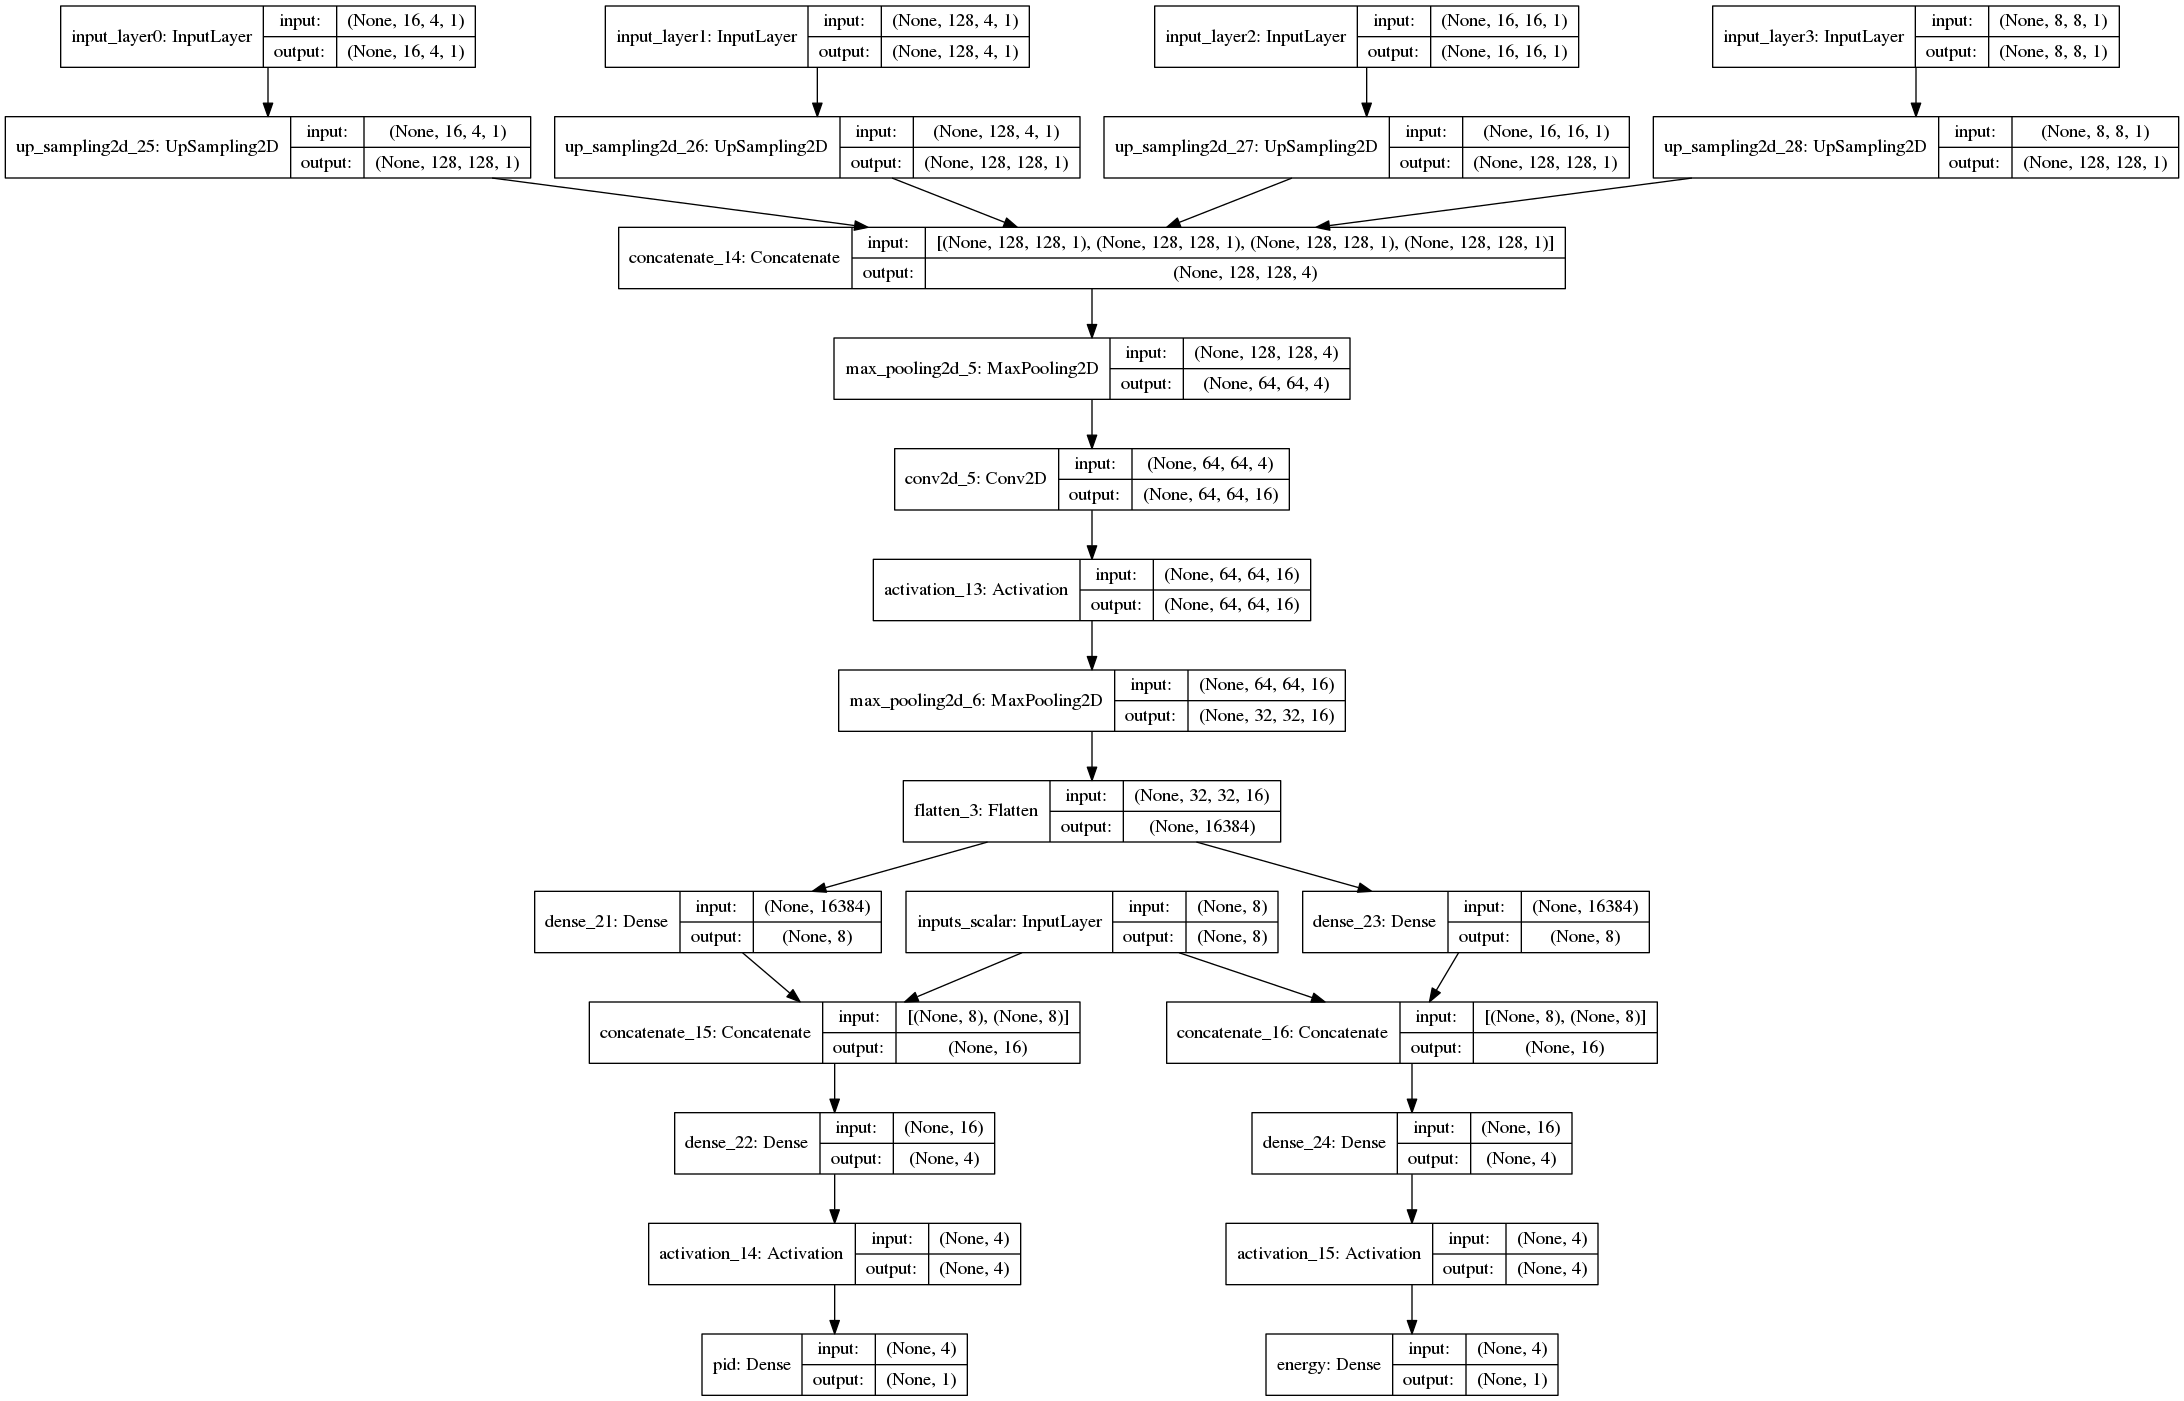

In [48]:
plot_model(cnn, to_file='figures/cnn.png', show_shapes=True)
Image(filename='figures/cnn.png')

Compile model.

In [49]:
cnn.compile(loss=["binary_crossentropy", "MSE"], optimizer="Adam")

Fit model.

In [ ]:
cnn.fit(X_train + [S_train], Y_train, batch_size=32, epochs=10, shuffle=True, validation_split=0.2)

Train on 64000 samples, validate on 16000 samples
Epoch 1/10
64000/64000 [==============================] - 152s - loss: 14.7746 - pid_loss: 0.3292 - energy_loss: 14.4454 - val_loss: 0.4170 - val_pid_loss: 0.4170 - val_energy_loss: 6.6117e-22
Epoch 2/10
64000/64000 [==============================] - 151s - loss: 3.3687 - pid_loss: 0.2852 - energy_loss: 3.0835 - val_loss: 0.3025 - val_pid_loss: 0.3025 - val_energy_loss: 1.4200e-27
Epoch 3/10
64000/64000 [==============================] - 159s - loss: 0.6289 - pid_loss: 0.2694 - energy_loss: 0.3595 - val_loss: 0.3014 - val_pid_loss: 0.3014 - val_energy_loss: 0.0000e+00
Epoch 4/10
64000/64000 [==============================] - 159s - loss: 0.2680 - pid_loss: 0.2680 - energy_loss: 0.0000e+00 - val_loss: 0.2347 - val_pid_loss: 0.2347 - val_energy_loss: 0.0000e+00
Epoch 5/10
 2976/64000 [>.............................] - ETA: 135s - loss: 0.2425 - pid_loss: 0.2425 - energy_loss: 0.0000e+00

Evaluate model on testing dataset.

In [17]:
# Predict event label and regressed quantities (e.g. ET)
y_pred, e_pred = cnn.predict(X_test + [S_test], batch_size=32)

# Conform to shape of target arrays
y_pred = y_pred.flatten()
e_pred = e_pred.flatten()

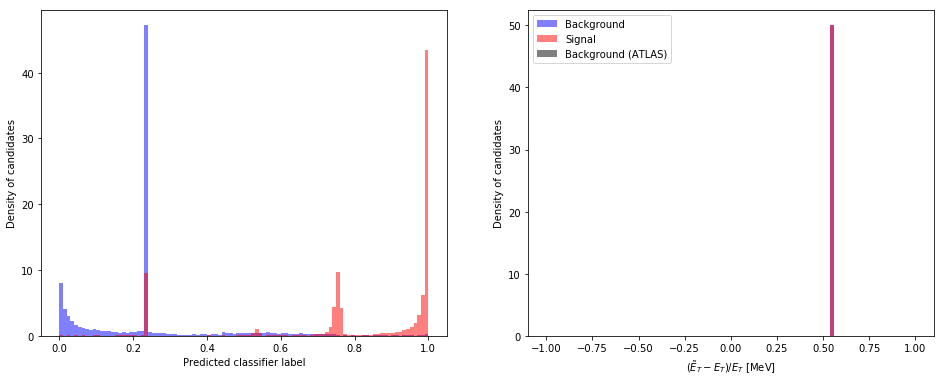

In [22]:
%matplotlib inline

# Define variable(s)
sig = (Y_test[0] == 1)
opts = dict(normed=True,alpha=0.5)
e_true  = Y_test[1]
e_atlas = data['p_E'][~msk_train] / 1000.

# Create figure
fig, ax = plt.subplots(1,2, figsize=(16,6))

# -- PID
opts.update({'bins': np.linspace(0, 1, 100 + 1, endpoint=True)})
ax[0].hist(y_pred[~sig], color='blue', label='Background', **opts)
ax[0].hist(y_pred[ sig], color='red',  label='Signal',     **opts)
ax[0].set_xlabel('Predicted classifier label')
ax[0].set_ylabel('Density of candidates')

# -- Energy regression
opts.update({'bins': np.linspace(-1, 1, 100 + 1, endpoint=True)})
ax[1].hist(((e_pred  - e_true))[~sig], color='blue',  label='Background', **opts)
ax[1].hist(((e_pred  - e_true))[ sig], color='red',   label='Signal',     **opts)
ax[1].hist(((e_atlas - e_true))[~sig], color='black', label='Background (ATLAS)', **opts)
ax[1].set_xlabel(r'$(\tilde{E}_{T} - E_{T})/E_{T}$ [MeV]')
ax[1].set_ylabel('Density of candidates')

# Decorations
plt.legend()

# Show
plt.show()